In [22]:
from mlem.api import serve, load, save
import os 
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import mlflow


In [23]:
# load the data 
df = pd.read_csv("/Users/jabras/rent_scrape/data/tokyo_model.csv")
# still could improve the model

In [25]:
df.info()
# make rent price an int, 
df['rent_price'] = df['rent_price'].astype(int)
# make rei price an int
df = df.replace('nan', '0')
df = df.replace('-', '0')
df['rei_price'] = df['rei_price'].astype(float)
# make shiki price an int
df['shikikin'] = df['shikikin'].astype(float)
# make maintenance price an int
df['maintenence_price'] = df['maintenence_price'].astype(int)
# fix year built 
#df['year_built'] = df['year_built'].str.split('築').str[0]
#df['year_built'] = df['year_built'].str.split('年').str[0]
## convert '新築' to 0
#df['year_built'] = df['year_built'].replace('新築', 0)
#df['year_built'] = df['year_built'].replace('新', 0)
#df['year_built'] = df['year_built'].astype(float)
# replace nans in floor with 0
df['floor'] = df['floor'].replace('nan', '0')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rent_price         450 non-null    float64
 1   address            450 non-null    object 
 2   sqr_m              450 non-null    float64
 3   name_place         450 non-null    object 
 4   rei_price          450 non-null    object 
 5   shikikin           450 non-null    object 
 6   maintenence_price  450 non-null    object 
 7   nearest_eki        450 non-null    object 
 8   apartment_type     450 non-null    object 
 9   year_built         9 non-null      object 
 10  ku_name            450 non-null    object 
 11  floor              423 non-null    float64
 12  house_type         450 non-null    object 
 13  Lat                0 non-null      float64
 14  Lon                0 non-null      float64
dtypes: float64(5), object(10)
memory usage: 52.9+ KB


In [24]:
df.year_built.unique()

array([nan, '新'], dtype=object)

In [ ]:
# make dummy variables for categorical variables
df = pd.get_dummies(df, columns = ["apartment_type", "house_type", "ku_name"])

In [17]:
# make test and train sets
train, test = train_test_split(df, test_size = 0.2, random_state = 42)


In [28]:
# use statsmodels to get a summary of the model and see what variables we want to include
sm_model = smf.ols('rent_price ~ rei_price + shikikin + maintenence_price + sqr_m + floor +C(apartment_type) + C(ku_name)', data = train).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rent_price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     34.76
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           2.34e-69
Time:                        11:42:00   Log-Likelihood:                -557.38
No. Observations:                 338   AIC:                             1159.
Df Residuals:                     316   BIC:                             1243.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.6336      0.937      7.080      0.000       4.790       8.477
C(apartment_type)[T.1K]       0.6519      0.486      1.341      0.181      -0.304       1.608
C(apartment_type)[T.1LDK]     1.1606      0.309      3.751      0.000       0.552       1.769
C(apartment_type)[T.2DK]     -0.7254      0.523     -1.388      0.166      -1.754       0.303
C(apartment_type)[T.2K]      -0.0968      0.229     -0.424      0.672      -0.547       0.353
C(apartment_type)[T.2SDK]     1.6544      0.841      1.967      0.050      -0.000       3.309
C(apartment_type)[T.2SK]     -3.5141      0.646     -5.443      0.000      -4.784      -2.244
C(ku_name)[T.中野]             -4.4327      0.491     -9.028      0.000      -5.399      -3.467
C(ku_name)[T.台東]             -3.8169      0.471     -8.107      0.000      -4.743      -2.891
C(ku_name)[T.品川]             -5.1243      0.559     -9.162      0.000      -6.225      -4.024
C(ku_name)[T.墨田]             -4.0282      0.588     -6.851      0.000      -5.185      -2.871
C(ku_name)[T.大田]          -2.448e-15   3.65e-16     -6.704      0.000   -3.17e-15   -1.73e-15
C(ku_name)[T.文京]             -3.6606      0.727     -5.032      0.000      -5.092      -2.229
C(ku_name)[T.新宿]             -2.1178      0.572     -3.701      0.000      -3.244      -0.992
C(ku_name)[T.杉並]             -4.1091      0.592     -6.944      0.000      -5.273      -2.945
C(ku_name)[T.江東]             -4.5660      0.515     -8.862      0.000      -5.580      -3.552
C(ku_name)[T.港]           -1.996e-15   2.57e-16     -7.766      0.000    -2.5e-15   -1.49e-15
C(ku_name)[T.目黒]             -3.7853      0.543     -6.977      0.000      -4.853      -2.718
C(ku_name)[T.荒川]             -4.5605      0.450    -10.137      0.000      -5.446      -3.675
rei_price                     0.2851      0.025     11.563      0.000       0.237       0.334
shikikin                      0.1068      0.019      5.625      0.000       0.069       0.144
maintenence_price             0.0004   4.13e-05      9.301      0.000       0.000       0.000
sqr_m                         0.0822      0.021      3.867      0.000       0.040       0.124
floor                        -0.1587      0.056     -2.817      0.005      -0.270      -0.048
==============================================================================
Omnibus:                       15.517   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.521
Skew:                           0.345   Prob(JB):                     1.29e-05
Kurtosis:                       4.060   Cond. No.                     2.41e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the er

In [19]:
model = LinearRegression().fit(train[['rei_price', 'shikikin', 'maintenence_price', 'sqr_m']], train['rent_price'])
# make model include other variables and play around with it a bit more

# log model with MLflow
with mlflow.start_run():
    mlflow.sklearn.log_model(model, 'statsmodels-lr')
    mlflow.log_metric('mse', mean_squared_error(test['rent_price'], model.predict(test[['rei_price', 'shikikin', 'maintenence_price', 'sqr_m']])))
    mlflow.log_param('test_size', 0.2)
    mlflow.log_param('random_state', 42)
    mlflow.log_param('model', 'LinearRegression')
    mlflow.log_param('features', ['rei_price', 'shikikin', 'maintenence_price', 'sqr_m'])
    

ValueError: could not convert string to float: '新'

In [30]:
# now see how it does on the test set
pred = model.predict(test[['rei_price', 'shikikin', 'maintenence_price', 'sqr_m']])
mse = mean_squared_error(test['rent_price'], pred)
print(mse)
if mse < 4:
    print("model is good")
    # and save it 
    # save the model
    path = os.path.join(os.getcwd(), "passed-model")
    save(model, path = path, sample_data = test[['rei_price', 'shikikin', 'maintenence_price', 'sqr_m']])

2.6535900325961204
model is good


In [31]:
#!mlem declare builder docker docker-builder.mlem \
#    --image.name mlem-model \
#    --server fastapi

💾 Saving builder to docker-builder.mlem


In [1]:
#!mlem serve fastapi --model passed-model

/var/folders/11/0jl_y2gs2l572wb1djp1qrjm0000gn/T/ipykernel_8622/2241902657.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid)


<Axes: xlabel='rent_price', ylabel='Density'>

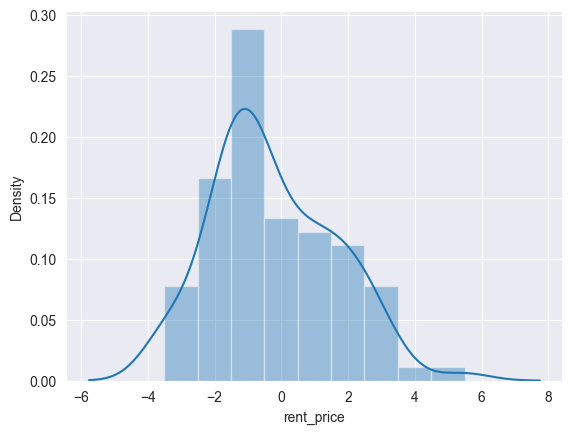

In [18]:
# see if our assumptions are met 
# normality of residuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
resid = (test.rent_price - pred)
sns.distplot(resid)

In [19]:
# check for heteroskedasticity
#import statsmodels.stats.api as sms
#import numpy as np
#test_result, p_value, _, two = sms.het_breuschpagan(model.resid, model.model.exog)
#print('Lagrange multiplier p-value: {}'.format(p_value))
#print('F-statistic p-value: {}'.format(two))
# we can see that the p-value is less than 0.05, so we reject the null hypothesis that there is no heteroskedasticity


In [ ]:
# now want to check for model drift 
import nannyml as nml 

# set target variable 
target = 'rent_price'
# set features
features = ['rei_price', 'shikikin', 'maintenence_price', 'sqr_m']

# make baseline predictions 
reference = X_test.copy()

# estimating model performance w/ nannyml 
dle = nml.DLE(
    metrics = ["mae"],
    y_true = "rent_price",
    y_pred = "y_pred",
    feature_column_names = features,
    timestamp_column_name = "timestamp", # will need to add this
)

dle.fit(reference)
estimated_performance = dle.estimate(analysis_df)
# https://github.com/NannyML/examples/blob/main/webinars/230119%20-%20Analyzing%20your%20model's%20performance%20in%20production/Monitoring%20ML%20models%20in%20production%20from%20a%20notebook.ipynb

In [ ]:
udc = nml.UnivariateDriftCalculator(
    column_names=['y_pred'],
    timestamp_column_name='lpep_pickup_datetime',
    chunk_period='d',
)

udc.fit(reference)
univariate_data_drift = udc.calculate(analysis_df)

univariate_data_drift.plot(kind='distribution')